# ESG-score using a MiniMax Model

## Problem setting:

As a Business-idea firm xy plans to launch a new app, in which clients are able to invest in a socially responsible manner. The app has to be able to compute for every portfolio an Environmental, Social and Governance (ESG) score between 0 and 100, where a higher score indicates a more responsible investment. Using an optimization process for each client a customized portfolio that takes into account the provided target values should be derived. Since firm xy is based in Switzerland, the initial investments universe comprises the stocks listed on SMI. The files prices1617.csv, prices18.csv and scores.csv contain the weekly closing prices of the SMI and its constituents for the years 2016-2017 and 2018 as well as the latest ESG scores for all SMI constituents, respectively.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import gurobipy as gb
import matplotlib.pyplot as plt

In [2]:
# Define precision of number display
pd.set_option('precision', 5)

In [3]:
# Import prices
weekly_prices = pd.read_csv('prices1617.csv', index_col='date')
# Look at first five rows
weekly_prices.head()

,SGS,SWISSCOM,GIVAUDAN,ZURICH INSURANCE,NOVARTIS,ROCHE,CREDIT SUISSE,ADECCO,LAFARGEHOLCIM,ABB,...,LONZA,SWISS LIFE,GEBERIT,NESTLE,JULIUS BAER,SWISS RE,RICHEMONT,UBS,SIKA,SMI
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1911,503.0,1823,258.4,86.80,276.4,20.929,68.047,50.30,17.96,...,151.078,271.3,340.2,74.55,48.66,98.15,72.10,19.52,60.335,8818.09
2016-01-08,1757,488.3,1714,241.4,82.10,263.0,19.028,62.368,46.00,16.43,...,143.668,257.2,318.1,70.30,44.18,93.25,66.05,17.46,58.584,8257.28
2016-01-15,1770,478.2,1772,242.8,80.35,256.5,18.054,59.356,42.26,16.18,...,138.017,262.3,332.3,70.10,42.02,92.60,63.10,16.71,58.451,8107.13
2016-01-22,1932,489.0,1812,224.4,82.90,265.3,17.359,60.837,44.12,16.77,...,143.575,256.8,342.4,72.10,42.59,92.60,64.35,16.83,58.818,8271.11
2016-01-29,1983,507.5,1907,225.8,78.50,263.9,17.369,61.726,42.92,17.57,...,144.779,259.6,361.8,75.20,43.25,94.80,66.25,16.83,60.951,8319.81


In [4]:
# Compute weekly returns
weekly_returns = weekly_prices / weekly_prices.shift(1) - 1
# Drop NA-return (first period)
weekly_returns = weekly_returns.dropna()
# Look at first five rows
weekly_returns.head()

,SGS,SWISSCOM,GIVAUDAN,ZURICH INSURANCE,NOVARTIS,ROCHE,CREDIT SUISSE,ADECCO,LAFARGEHOLCIM,ABB,...,LONZA,SWISS LIFE,GEBERIT,NESTLE,JULIUS BAER,SWISS RE,RICHEMONT,UBS,SIKA,SMI
date,,,,,,,,,,,,,,,,,,,,,
2016-01-08,-0.08059,-0.02922,-0.05979,-0.06579,-0.05415,-0.04848,-0.09083,-0.08346,-0.08549,-0.08519,...,-0.04905,-0.05197,-0.06496,-0.05701,-0.09207,-0.04992,-0.08391,-0.10553,-0.02902,-0.06360
2016-01-15,0.00740,-0.02068,0.03384,0.00580,-0.02132,-0.02471,-0.05119,-0.04829,-0.08130,-0.01522,...,-0.03933,0.01983,0.04464,-0.00284,-0.04889,-0.00697,-0.04466,-0.04296,-0.00227,-0.01818
2016-01-22,0.09153,0.02258,0.02257,-0.07578,0.03174,0.03431,-0.03850,0.02495,0.04401,0.03646,...,0.04027,-0.02097,0.03039,0.02853,0.01356,0.00000,0.01981,0.00718,0.00628,0.02023
2016-01-29,0.02640,0.03783,0.05243,0.00624,-0.05308,-0.00528,0.00058,0.01461,-0.02720,0.04770,...,0.00839,0.01090,0.05666,0.04300,0.01550,0.02376,0.02953,0.00000,0.03626,0.00589
2016-02-05,-0.00050,-0.04926,-0.02727,-0.05492,-0.05860,-0.04433,-0.16944,-0.04240,-0.09110,0.00171,...,-0.06206,-0.06895,-0.02073,-0.02460,-0.08393,-0.05432,-0.01132,-0.09626,-0.00710,-0.04323


In [5]:
# Compute expected returns
all_expected_returns = weekly_returns.mean()
all_expected_returns

SGS                 0.00303
SWISSCOM            0.00048
GIVAUDAN            0.00229
ZURICH INSURANCE    0.00178
NOVARTIS           -0.00014
ROCHE              -0.00075
CREDIT SUISSE      -0.00044
ADECCO              0.00132
LAFARGEHOLCIM       0.00155
ABB                 0.00394
SWATCH              0.00190
LONZA               0.00575
SWISS LIFE          0.00269
GEBERIT             0.00250
NESTLE              0.00129
JULIUS BAER         0.00250
SWISS RE           -0.00038
RICHEMONT           0.00243
UBS                 0.00002
SIKA                0.00768
SMI                 0.00076
dtype: float64

In [6]:
# Get array of stocks (without index SMI)
stocks = weekly_returns.columns.drop('SMI')

## Portfolio 1 (P1):
As a first idea for a portfolio selection an equally weighted portfolio approach is chosen. This portfolio is referred by P1.
In a first step the variance, mean-absolute deviation, Beta (relative to SMI), minimum return and the expected downside $(r_t =1\%)$ for the portfolio P1 as well as for the SMI are computed.

In [7]:
# Create equally weighted portfolio
weights_p1 = pd.Series(1 / len(stocks), index=stocks)
weekly_returns['P1'] = weekly_returns[stocks].dot(weights_p1)

In [8]:
# Calculate variance
weekly_returns[['P1', 'SMI']].var()

P1     0.00037
SMI    0.00032
dtype: float64

In [9]:
# Calculate mean-absolute deviation
weekly_returns[['P1', 'SMI']].mad()

P1     0.01401
SMI    0.01338
dtype: float64

In [10]:
# Compute the beta of P1
weekly_returns['P1'].cov(weekly_returns['SMI']) / weekly_returns['SMI'].var()

0.9763988106997943

In [11]:
# Compute the beta of SMI
weekly_returns['SMI'].cov(weekly_returns['SMI']) / weekly_returns['SMI'].var()

1.0

In [12]:
# Compute the minimum return
weekly_returns[['P1', 'SMI']].min()

P1    -0.06835
SMI   -0.06360
dtype: float64

In [13]:
# Define target return
target_return = 0.01

# Compute expected downside with respect to given target return
np.maximum(0, -(weekly_returns[['P1', 'SMI']] - target_return)
          ).sum() / weekly_returns['P1'].size

P1     0.01160
SMI    0.01221
dtype: float64

### Note:
In a next step the ESG Environmental, ESG Governance and ESG Social scores of P1 are computed.

In [14]:
# Import ratings
scores = pd.read_csv('scores.csv', index_col='scores')

In [15]:
# Look at first five rows
scores.head()

,SGS,SWISSCOM,GIVAUDAN,ZURICH INSURANCE,NOVARTIS,ROCHE,CREDIT SUISSE,ADECCO,LAFARGEHOLCIM,ABB,SWATCH,LONZA,SWISS LIFE,GEBERIT,NESTLE,JULIUS BAER,SWISS RE,RICHEMONT,UBS,SIKA
scores,,,,,,,,,,,,,,,,,,,,
ESG Environmental,80,89,72,93,75,97,88,70,60,96,62,97,81,91,85,79,92,66,91,85
ESG Social,97,61,63,75,85,95,82,77,81,96,38,97,71,74,94,66,70,71,97,49
ESG Governance,75,74,66,81,66,68,77,77,68,79,16,58,34,53,49,77,71,38,89,45


In [16]:
# Get ESG scores for P1
scores.dot(weights_p1)

scores
ESG Environmental    82.45
ESG Social           76.95
ESG Governance       63.05
dtype: float64

### Question:
Does a distinct relationship between the expected returns and the average ESG scores exist? Do more sustainable stocks tend to have greatly inferior performance than less sustainable stocks?

In [17]:
# Get average ESG scores
average_esg_score = scores.mean()

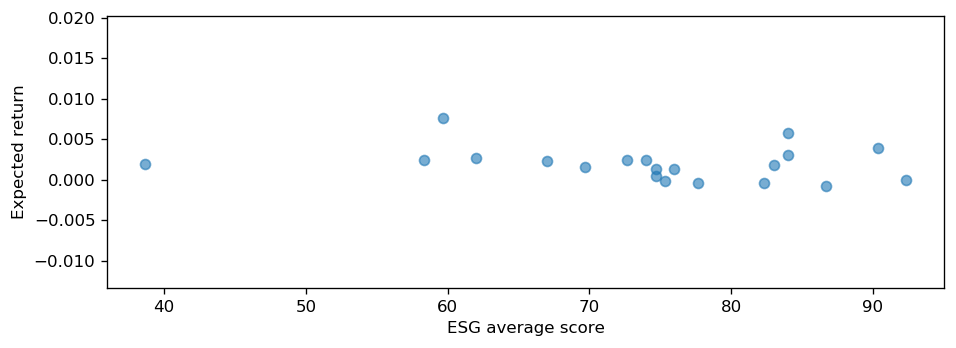

In [18]:
# Visualize average ESG scores and expected returns in scatterplot
plt.figure(figsize=(9, 3), dpi=120)
plt.scatter(average_esg_score, all_expected_returns[stocks], alpha=0.6)
plt.xlabel('ESG average score')
plt.ylabel('Expected return');

The data does not support the claim. It appears that no distinct relationship between the expected returns and the average ESG scores exist.

## Portfolio 2 (P2):
As an alternative the firm xy has the idea to implement a MiniMax model as the underlying portfolio selection model (P2). Further a blacklist is introduced that consist of two pharmaceutical companies: Novartis and Roche. The weights for stocks on the blacklist must be zero in all subsequent portfolios.


### Note:
A MiniMax(MM) model trades off the minimum portfolio rerun against the expected portfolio return. Therefore the minimum portfolio return is a downside risk measure. It is possible to formulate a MM model as a linear optimization problem. 

Some technical characteristics of the MM model:
* Minimum return is homogeneous
* Minimum return is monotone
* Minimum return is subadditive
* Minimum return is translational invariant

=> Therefore the Minimum return is coherent



Notation: 
* $\alpha$ Minimum portfolio return over all scenarios

\begin{align}
Max. \alpha\\ 
\sum_{i=n}^n r_{il}x_i \geq \alpha \quad (l \in \Omega)\\ 
\sum_{i=n}^n \bar r_ix_i = \mu \\
\sum_{i=n}^n x_i =1 \\
x_i \geq 0 \quad (i =1,...,n) \\
\alpha \in \Re
\end{align}

In [19]:
# Get array of scenarios
scenarios = weekly_returns.index
# Compute expected returns
expected_returns = all_expected_returns[stocks]
# Define target portfolio return
target_return = all_expected_returns['SMI']

In [20]:
# Create model
m = gb.Model('MM')

# Add a variable for each stock
x = pd.Series(m.addVars(stocks), index=stocks)

# Add a variable which represents the minimum portfolio return
minimum_return = m.addVar(lb=weekly_returns[stocks].min().min())

# Define portfolio return
portfolio_return = expected_returns.dot(x)

# Add objective function to model
m.setObjective(minimum_return, gb.GRB.MAXIMIZE)

# Add minimum return constraints
for l in scenarios:
    m.addConstr(weekly_returns.loc[l, stocks].dot(x) >= minimum_return)
    
# Add budget constraint
m.addConstr(x.sum() == 1);

# Add target return constraint
target_return_constr = m.addConstr(portfolio_return == target_return)

# Add blacklist constraints
m.addConstr(x.loc['ROCHE'] == 0)
m.addConstr(x.loc['NOVARTIS'] == 0);

# Specify Gurobi options
m.setParam('OutputFlag', 0)

# Run optimization
m.optimize()

# Get weights of stocks in optimal solution
weights_p2 = pd.Series([var.X for var in x], index=stocks)

# Get ESG scores for P2
scores[stocks].dot(weights_p2)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xeb in position 30: invalid continuation byte

Academic license - for non-commercial use only


Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "extern.pxi", line 19, in gurobipy.__bytestostring
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xeb in position 30: invalid continuation byte


scores
ESG Environmental    86.43303
ESG Social           66.29855
ESG Governance       65.06492
dtype: float64

### Question:
What is the minimum return of P2 and how does it stand up compared to the SMI?

In [21]:
# Get minimum return of P2
minimum_return_p2 = minimum_return.X
minimum_return_p2

-0.03953015537895124

In [22]:
# Is minimum return of P2 bigger than minimum return of SMI?
minimum_return.X > weekly_returns['SMI'].min()

True

The minimum return of P2 (-0.03953) is larger (less negative) than the minimum return of the SMI (-0.06360) and thus, the SMI is not efficient

In [23]:
# Get weights of stocks in optimal solution
weights_p2

SGS                 0.00000
SWISSCOM            0.72773
GIVAUDAN            0.00000
ZURICH INSURANCE    0.00000
NOVARTIS            0.00000
ROCHE               0.00000
CREDIT SUISSE       0.00000
ADECCO              0.00000
LAFARGEHOLCIM       0.00000
ABB                 0.00000
SWATCH              0.06426
LONZA               0.00000
SWISS LIFE          0.00000
GEBERIT             0.00000
NESTLE              0.20606
JULIUS BAER         0.00000
SWISS RE            0.00000
RICHEMONT           0.00000
UBS                 0.00000
SIKA                0.00196
dtype: float64

## Note:
Adjust the target return constraint of the model such that the optimal portfolio has an expected return equal to or greater than the target return (P3). 

\begin{align}
Max. \alpha\\ 
\sum_{i=n}^n r_{il}x_i \geq \alpha \quad (l \in \Omega)\\ 
\sum_{i=n}^n \bar r_ix_i \geq \mu \\
\sum_{i=n}^n x_i =1 \\
x_i \geq 0 \quad (i =1,...,n) \\
\alpha \in \Re
\end{align}

In [24]:
# Remove old target return constraint
m.remove(target_return_constr)

In [25]:
# Add new target return constraint
target_return_constr = m.addConstr(portfolio_return >= target_return)

In [26]:
# Run optimization
m.optimize()

In [27]:
# Get minimum return of P3
minimum_return.X

-0.03195969273382321

The minimum return impoves from -3.95% in P2 to -3.2% in P3.

In [28]:
# Get weights of stocks in optimal solution
weights_p3 = pd.Series([var.X for var in x], index=stocks)
weights_p3

SGS                 0.00000
SWISSCOM            0.52387
GIVAUDAN            0.00000
ZURICH INSURANCE    0.00000
NOVARTIS            0.00000
ROCHE               0.00000
CREDIT SUISSE       0.00000
ADECCO              0.00000
LAFARGEHOLCIM       0.00000
ABB                 0.00000
SWATCH              0.00000
LONZA               0.00000
SWISS LIFE          0.00000
GEBERIT             0.00000
NESTLE              0.10118
JULIUS BAER         0.00000
SWISS RE            0.00000
RICHEMONT           0.00000
UBS                 0.00000
SIKA                0.37495
dtype: float64

## Portfolio 4 (P4)
In order to develop a variant of the minimax model that additionally takes into account the investors' target values for the three ESG score a separate penalty for each of the three ESG scores is implemented. If the portfolio score is equal to or greater than the target value, then the penalty is zero. If the portfolio score is smaller than the target value, then the penalty corresponds to the difference between the target value and the portfolio score.
$penalty_{ESG} = max(taregt ESG score - portfolio ESG score,0)$ 

However, firm xy decides that a linear increasing penalty is not appropriate. It should be ensured that large shortfalls are penalized heavily. The structure of the three penalty functions can be seen in the following graphs:

![title](picture.PNG)


Additionally the already introduced constraints have to hold:
* The portfolio return does not fall below a prespecified minimum portfolio return $\alpha$ in any scenario.
* The expected portfolio return is equal to or greater than a prespecified target return µ.
* The sum of the weights is equal to 1.
* All portfolio weights are non-negative.
* The weights for stocks on the blacklist must be zero.

Formulate a linear optimization problem in which the sum of the three penalties (given the structures in the graphs) is minimized subject to all constraints.

### Note:
The resulting optimization problem:

Notation:
* $S_i^E$: ESG Envionmental score of stock i
* $S_i^S$: ESG Social score of stock i
* $S_i^G$: ESG Governance score of stock i
* $S_t^E$: Target ESG Environmental value
* $S_t^S$: Target ESG Socail value
* $S_t^G$: Target ESG Governance value
* $x_i$: weight of asset i
* $\delta_{Ej}$:  Shortfall of portfolio ESG Environmental score with respect to target ESG Environmental value in jth segment of penalty function (j = 1; 2)
* $\delta_{Sj}$: Shortfall of portfolio ESG Social score with respect to target ESG Social value in jth segment of penalty function (j = 1; 2)
* $\delta_{Gj}$: Shortfall of portfolio ESG Governance score with respect to target ESG Governance value in jth segment of penalty function (j = 1; 2) 


\begin{align}
Min. (8/10)\delta_{E1} + (12/10)\delta_{E2} + (10/10)\delta_{S1} + (20/10)\delta_{S2} + (4/10) \delta_{G1} + (8/10)\delta_{G2}\\
\sum_{i=n}^n r_{il}x_i \geq \alpha \quad (l \in \Omega)\\ 
\sum_{i=n}^n \bar r_ix_i \geq \mu \\
\sum_{i=n}^n x_i =1 \\
\sum_{i=n}^n S_i^E x_i  \geq S_t^E - \delta_{E1} - \delta_{E2}\\
\sum_{i=n}^n S_i^S x_i  \geq S_t^S - \delta_{S1} - \delta_{S2}\\
\sum_{i=n}^n S_i^G x_i  \geq S_t^G - \delta_{G1} - \delta_{G2}\\
\delta_{E1} \leq 10 \\
\delta_{S1} \leq 10 \\
\delta_{G1} \leq 10 \\
x_i \geq 0 \quad (i =1,...,n) \\
x_i = 0 \quad (i = Novartis, Roche)\\
\delta_{E1},\delta_{E2},\delta_{S1},\delta_{S2},\delta_{G1},\delta_{G2} \geq 0\\
\end{align}


In [29]:
# Define target ESG values
S_t_E = 100
S_t_S = 100
S_t_G = 100

In [30]:
# Create model
m = gb.Model('MM2')

# Add a variable for each stock
x = pd.Series(m.addVars(stocks), index=stocks)

# Add variables for ESG environmental penalties
delta_e1 = m.addVar()
delta_e2 = m.addVar()

# Add variables for ESG social penalties
delta_s1 = m.addVar()
delta_s2 = m.addVar()

# Add variables for ESG governance penalties
delta_g1 = m.addVar()
delta_g2 = m.addVar()

# Define minimum return
minimum_return = minimum_return_p2

# Define portfolio return
portfolio_return = expected_returns.dot(x)

# Define portfolio environmental score
portfolio_environmental_score = scores.loc['ESG Environmental', stocks].dot(x)

# Define portfolio social score
portfolio_social_score = scores.loc['ESG Social', stocks].dot(x)

# Define portfolio governance score
portfolio_governance_score = scores.loc['ESG Governance', stocks].dot(x)

# Add objective function to model
m.setObjective((8 / 10) * delta_e1 + (12 / 10) * delta_e2
               + (10 / 10) * delta_s1 + (20 / 10) * delta_s2
               + (4 / 10) * delta_g1 + (8 / 10) * delta_g2, gb.GRB.MINIMIZE)

# Add constraints for ESG penalties to model
ESG_environmental_penalty_constraint = m.addConstr(
    portfolio_environmental_score >= S_t_E - delta_e1 - delta_e2)
ESG_social_penalty_constraint = m.addConstr(
    portfolio_social_score >= S_t_S - delta_s1 - delta_s2)
ESG_governance_penalty_constraint = m.addConstr(
    portfolio_governance_score >= S_t_G - delta_g1 - delta_g2)
m.addConstr(delta_e1 <= 10)
m.addConstr(delta_s1 <= 10)
m.addConstr(delta_g1 <= 10);

# Add minimum return constraints
for l in scenarios:
    m.addConstr(weekly_returns.loc[l, stocks].dot(x) >= minimum_return)

    
# Add budget constraint
m.addConstr(x.sum() == 1);    

# Add blacklist constraints
m.addConstr(x.loc['ROCHE'] == 0)
m.addConstr(x.loc['NOVARTIS'] == 0);

# Add target return constraint
m.addConstr(portfolio_return >= target_return);

# Specify Gurobi options
m.setParam('OutputFlag', 0)

# Run optimization
m.optimize()

# Get portfolio return
portfolio_return.getValue()

0.004028207115997125

In [31]:
# Get weights of stocks in optimal solution
weights_p4 = pd.Series([var.X for var in x], index=stocks)
weights_p4

SGS                 0.00000
SWISSCOM            0.29316
GIVAUDAN            0.00000
ZURICH INSURANCE    0.00000
NOVARTIS            0.00000
ROCHE               0.00000
CREDIT SUISSE       0.00000
ADECCO              0.00000
LAFARGEHOLCIM       0.00000
ABB                 0.00000
SWATCH              0.00000
LONZA               0.31895
SWISS LIFE          0.00000
GEBERIT             0.00000
NESTLE              0.14513
JULIUS BAER         0.00000
SWISS RE            0.00000
RICHEMONT           0.00000
UBS                 0.00000
SIKA                0.24276
dtype: float64

In [32]:
# Get ESG ratings P3
scores[stocks].dot(weights_p3)

scores
ESG Environmental    87.09548
ESG Social           59.83969
ESG Governance       60.59696
dtype: float64

In [33]:
# Get ESG Environmental score for P4
portfolio_environmental_score.getValue()

90.0

In [34]:
# Get ESG Social score for P4
portfolio_social_score.getValue()

74.3583947757379

In [35]:
# Get ESG Governance score for P4
portfolio_governance_score.getValue()

58.22836587606057

### Question:
Assume that the model and the parameters $\alpha$ and $\mu$ are given from above. Is it possible to consturct a portfolio with its Envionmental score beeing at least 70 and 65 for the Social and Governance scores? If yes, what is the expected portfolio return?

In [36]:
# Adjust right-hand side of ESG penalty constraints
ESG_environmental_penalty_constraint.rhs = 70
ESG_social_penalty_constraint.rhs = 65
ESG_governance_penalty_constraint.rhs = 65

In [37]:
# Specify Gurobi options
m.setParam('OutputFlag', 0)

In [38]:
# Run optimization
m.optimize()

In [39]:
# Get portfolio return
portfolio_return.getValue()

0.0008908322172577389

In [40]:
# Get objective function value
m.ObjVal

0.0

In [41]:
# Get ESG Environmental score
portfolio_environmental_score.getValue()

87.44291684099434

In [42]:
# Get ESG Social score
portfolio_social_score.getValue()

72.74805099526803

In [43]:
# Get ESG Governance score
portfolio_governance_score.getValue()

65.00000000000001

### Note:
Yes, such a portfolio is possible to construct without having to take on a penalty which is indidicated by the objective value beeing equal to zero. Further such a portfolio would have a expected return of 0.18%.

### Question:
Given an investor whose main concern only consists of the highest possible Governance score? How would such a portfolio look like and what are the associated ESG-scores? 

In [44]:
# Adjust right-hand side of ESG penalty constraints
ESG_environmental_penalty_constraint.rhs = 0
ESG_social_penalty_constraint.rhs = 0
ESG_governance_penalty_constraint.rhs = 100

In [45]:
# Specify Gurobi options
m.setParam('OutputFlag', 0)

In [46]:
# Run optimization
m.optimize()

In [47]:
# Get portfolio return
portfolio_return.getValue()

0.001378912909258574

In [48]:
# Get objective function value
m.ObjVal

16.899489938619062

In [49]:
# Get ESG Environmental score
portfolio_environmental_score.getValue()

90.10740054392176

In [50]:
# Get ESG Social score
portfolio_social_score.getValue()

66.65023035929603

In [51]:
# Get ESG Governance score
portfolio_governance_score.getValue()

73.87563757672618

### Note:
A portfolio ESG Governance score of 73.88 can be achieved. The portfolio ESG Social score takes a value of 66.65 and the portfolio ESG Enviornmental score a value of 90.11.

## Perfomance evalation
In order to evaluate our portfolios (P1-P4) and the SMI we use a second datasample containing of the weekly closing prices from the year 2018. Imagine that 1'000'000 CHF are invesed in each portflio and that it is possible to buy a fracitonal number of units.

In [52]:
# Import prices
weekly_prices_evaluation = pd.read_csv('prices18.csv', index_col='date')
weekly_prices_evaluation.head()

,SGS,SWISSCOM,GIVAUDAN,ZURICH INSURANCE,NOVARTIS,ROCHE,CREDIT SUISSE,ADECCO,LAFARGEHOLCIM,ABB,...,LONZA,SWISS LIFE,GEBERIT,NESTLE,JULIUS BAER,SWISS RE,RICHEMONT,UBS,SIKA,SMI
date,,,,,,,,,,,,,,,,,,,,,
2018-01-05,2602,524.8,2327,300.1,84.08,252.20,17.640,78.90,58.00,26.92,...,270.9,350.7,436.7,83.74,61.46,92.26,89.54,18.360,134.503,9556.98
2018-01-12,2575,520.4,2270,313.6,83.88,245.80,18.290,79.42,58.90,27.13,...,264.5,356.0,430.0,82.48,63.24,92.96,89.34,18.895,138.419,9546.61
2018-01-19,2635,520.0,2295,317.6,83.38,234.50,18.280,78.90,59.58,26.98,...,270.2,358.8,463.0,82.28,63.86,94.46,90.10,19.325,139.003,9509.77
2018-01-26,2559,518.8,2211,315.3,87.74,231.45,18.605,78.78,58.94,26.56,...,270.6,357.0,450.5,81.00,63.66,93.54,88.80,19.355,136.419,9515.56
2018-02-02,2469,506.8,2179,307.8,82.64,224.15,18.060,75.30,56.28,25.67,...,251.6,351.2,435.6,79.42,63.58,92.22,88.78,18.940,130.336,9220.69


In [53]:
# get budget
budget=1000000

In [54]:
# get budget per stock
budget_per_stock_p1 = budget * weights_p1
budget_per_stock_p2 = budget * weights_p2
budget_per_stock_p3 = budget * weights_p3
budget_per_stock_p4 = budget * weights_p4

In [55]:
unit_per_stock_p1 = (budget_per_stock_p1 / weekly_prices_evaluation.loc['2018-01-05', stocks])
unit_per_stock_p2 = (budget_per_stock_p2 / weekly_prices_evaluation.loc['2018-01-05', stocks])
unit_per_stock_p3 = (budget_per_stock_p3 / weekly_prices_evaluation.loc['2018-01-05', stocks])
unit_per_stock_p4 = (budget_per_stock_p4 / weekly_prices_evaluation.loc['2018-01-05', stocks])
unit_smi = (budget / weekly_prices_evaluation.loc['2018-01-05', 'SMI'])

In [56]:
# Convert index from string to date
weekly_prices_evaluation.index = pd.to_datetime(weekly_prices_evaluation.index)

In [57]:
# Compute value development of portfolios
value_p1_evaluation = weekly_prices_evaluation[stocks].dot(unit_per_stock_p1)
value_p2_evaluation = weekly_prices_evaluation[stocks].dot(unit_per_stock_p2)
value_p3_evaluation = weekly_prices_evaluation[stocks].dot(unit_per_stock_p3)
value_p4_evaluation = weekly_prices_evaluation[stocks].dot(unit_per_stock_p4)
value_smi_evaluation = weekly_prices_evaluation['SMI'] * unit_smi

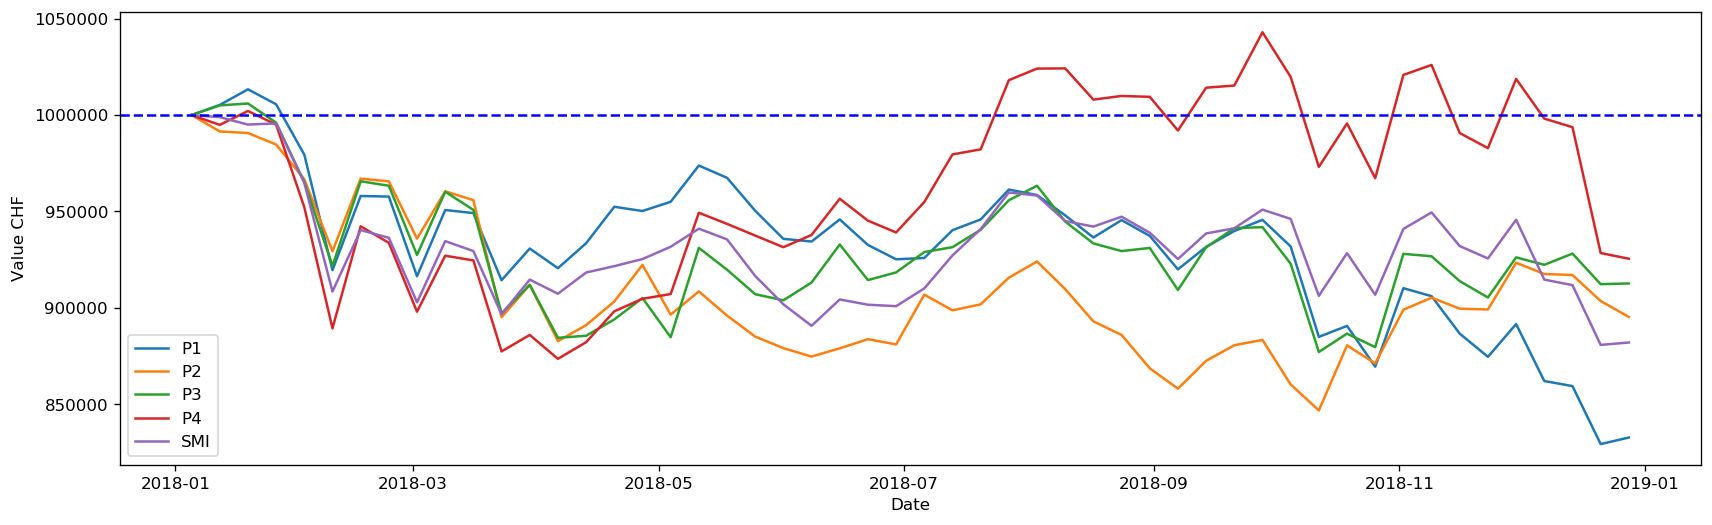

In [58]:
%matplotlib inline
# Line plot of value development of portfolios
plt.figure(figsize=(17, 5), dpi=120)
plt.plot(value_p1_evaluation, label='P1')
plt.plot(value_p2_evaluation, label='P2')
plt.plot(value_p3_evaluation, label='P3')
plt.plot(value_p4_evaluation, label='P4')
plt.plot(value_smi_evaluation, label='SMI')
plt.axhline(1000000, color='b', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value CHF')
plt.legend();

In [59]:
# Get values on 28th December, 2018
print('Value P1:', value_p1_evaluation.loc['2018-12-28'].round(2))
print('Value P2:', value_p2_evaluation.loc['2018-12-28'].round(2))
print('Value P3:', value_p3_evaluation.loc['2018-12-28'].round(2))
print('Value P4:', value_p4_evaluation.loc['2018-12-28'].round(2))
print('Value SMI:', value_smi_evaluation.loc['2018-12-28'].round(2))

Value P1: 832696.03
Value P2: 895256.94
Value P3: 912630.88
Value P4: 925445.21
Value SMI: 882004.57


## Question:
Compute  portfolio return and the minimum portfolio return of P1-P4 and the SMI for the years 2016-2017 as well as for the year 2018 and compare them to one another?

### 2016-2017

In [60]:
# Get unit per stock (assumption: investment of 1,000,000 CHF at beginning of year 2016)
unit_per_stock_p1 = (budget_per_stock_p1
                     / weekly_prices.loc['2016-01-01', stocks])
unit_per_stock_p2 = (budget_per_stock_p2
                     / weekly_prices.loc['2016-01-01', stocks])
unit_per_stock_p3 = (budget_per_stock_p3
                     / weekly_prices.loc['2016-01-01', stocks])
unit_per_stock_p4 = (budget_per_stock_p4
                     / weekly_prices.loc['2016-01-01', stocks])
unit_smi = (budget
            / weekly_prices.loc['2016-01-01', 'SMI'])

In [61]:
# Compute value development of portfolios
value_p1 = weekly_prices[stocks].dot(unit_per_stock_p1)
value_p2 = weekly_prices[stocks].dot(unit_per_stock_p2)
value_p3 = weekly_prices[stocks].dot(unit_per_stock_p3)
value_p4 = weekly_prices[stocks].dot(unit_per_stock_p4)
value_smi = weekly_prices['SMI'] * unit_smi

In [62]:
# Compute weekly returns for P1-P4
return_p1 = value_p1 / value_p1.shift(1) - 1
return_p2 = value_p2 / value_p2.shift(1) - 1
return_p3 = value_p3 / value_p3.shift(1) - 1
return_p4 = value_p4 / value_p4.shift(1) - 1
return_smi = value_smi / value_smi.shift(1) - 1

In [63]:
# Drop NA-return in first period
return_p1 = return_p1.dropna()
return_p2 = return_p2.dropna()
return_p3 = return_p3.dropna()
return_p4 = return_p4.dropna()
return_smi = return_smi.dropna()

In [64]:
# Get average portfolio return (in-sample)
print('In-sample')
print('Average return P1:', return_p1.mean())
print('Average return P2:', return_p2.mean())
print('Average return P3:', return_p3.mean())
print('Average return P4:', return_p4.mean())
print('Average return SMI:', return_smi.mean())

In-sample
Average return P1: 0.0019377459805753254
Average return P2: 0.000705162492983614
Average return P3: 0.0037536328656517706
Average return P4: 0.004306274155725259
Average return SMI: 0.0007559592715326025


In [65]:
# Get minimum portfolio return (in-sample)
print('In-sample')
print('Minimum return P1:', return_p1.min())
print('Minimum return P2:', return_p2.min())
print('Minimum return P3:', return_p3.min())
print('Minimum return P4:', return_p4.min())
print('Minimum return SMI:', return_smi.min())

In-sample
Minimum return P1: -0.0683472154943835
Minimum return P2: -0.039585853183499164
Minimum return P3: -0.03968848468003894
Minimum return P4: -0.039530155378951104
Minimum return SMI: -0.06359767251184767


### 2018

In [66]:
# Compute weekly returns for P1-P4
return_p1_evaluation = value_p1_evaluation / value_p1_evaluation.shift(1) - 1
return_p2_evaluation = value_p2_evaluation / value_p2_evaluation.shift(1) - 1
return_p3_evaluation = value_p3_evaluation / value_p3_evaluation.shift(1) - 1
return_p4_evaluation = value_p4_evaluation / value_p4_evaluation.shift(1) - 1
return_smi_evaluation = value_smi_evaluation / value_smi_evaluation.shift(1) - 1

In [67]:
# Drop NA-return in first period
return_p1_evaluation = return_p1_evaluation.dropna()
return_p2_evaluation = return_p2_evaluation.dropna()
return_p3_evaluation = return_p3_evaluation.dropna()
return_p4_evaluation = return_p4_evaluation.dropna()
return_smi_evaluation = return_smi_evaluation.dropna()

In [68]:
# Get average portfolio return (out-of-sample)
print('Out-of-sample')
print('Average return P1:', return_p1_evaluation.mean())
print('Average return P2:', return_p2_evaluation.mean())
print('Average return P3:', return_p3_evaluation.mean())
print('Average return P4:', return_p4_evaluation.mean())
print('Average return SMI:', return_smi_evaluation.mean())

Out-of-sample
Average return P1: -0.0033525014939166094
Average return P2: -0.0019677108825276166
Average return P3: -0.001528400014162195
Average return P4: -0.0011511241950784045
Average return SMI: -0.0022559037116565627


In [69]:
# Get minimum portfolio return (out-of-sample)
print('Out-of-sample')
print('Minimum return P1:', return_p1_evaluation.min())
print('Minimum return P2:', return_p2_evaluation.min())
print('Minimum return P3:', return_p3_evaluation.min())
print('Minimum return P4:', return_p4_evaluation.min())
print('Minimum return SMI:', return_smi_evaluation.min())

Out-of-sample
Minimum return P1: -0.06117459158716576
Minimum return P2: -0.0634980532456666
Minimum return P3: -0.056372769211856744
Minimum return P4: -0.06604151320746465
Minimum return SMI: -0.058421875152510294
